In [1]:
from vlm_finetune import AutoVlmModel, ImageProcessor
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import json
import evaluate
import pandas as pd

### Проведём оценку англоязычной модели, зафайнтюненной на демо-ноутбуках

Загружаем датасет и создаём функция для предикта на сэмпле

In [2]:
with open("data/vet_dataset_test_eng.json", "r") as file:
    test_data = json.loads(file.read())
prompt = "Make a probable diagnosis using the x-ray."


def predict_on_test_dataset(model_name: str, model_path: str, test_data: list[dict[str, str]], prompt: str) -> list[str]:
    answers = []
    model = AutoVlmModel.from_name(
        model_name=model_name, 
        model_path=model_path,
        image_processor=ImageProcessor(image_size=(336, 336)) # ресайзим картинки, чтобы сэкономить память
    )
    for sample in tqdm(test_data):
        model_answer = model.predict(image=sample["image_path"], prompt=prompt)
        answers.append(model_answer)
    return answers

### Предикты LLava eng

In [3]:
llava_answers = predict_on_test_dataset(
    model_name="llava",
    model_path="models/llava_tuned_eng",
    test_data=test_data,
    prompt=prompt
)

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

### Оценка модели по bertscore

Используем bertscore

In [4]:
bertscore = evaluate.load("bertscore")
answers = [td["answer"] for td in test_data]
llava_score = bertscore.compute(predictions=llava_answers, references=answers, lang="en")

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [5]:
eval_df = pd.DataFrame(
    {
        "answer": answers,
        "llava_answer": llava_answers,
        "llava_precision": llava_score["precision"],
        "llava_recall": llava_score["recall"],
        "llava_f1": llava_score["f1"],
    }
)
eval_df.to_csv("data/llava_eng_eval.csv", index=False, sep=";")
eval_df.describe()

,llava_precision,llava_recall,llava_f1
count,25.000000,25.000000,25.000000
mean,0.904407,0.871583,0.887460
std,0.043698,0.033291,0.035863
min,0.802818,0.819824,0.811933
25%,0.871950,0.839596,0.862117
50%,0.932167,0.878175,0.885354
75%,0.939365,0.897487,0.919474
max,0.961712,0.921229,0.941035


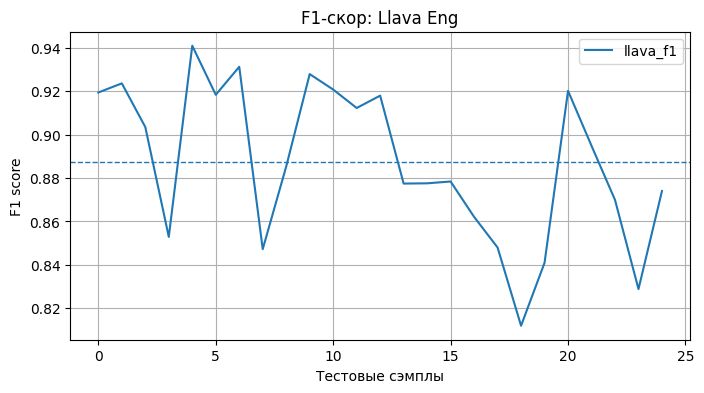

In [6]:
ax = eval_df[["llava_f1"]].plot(kind="line", figsize=(8, 4), title="F1-скор: Llava Eng")
ax.set_xlabel("Тестовые сэмплы")
ax.set_ylabel("F1 score")
ax.axhline(eval_df["llava_f1"].mean(), linestyle="--", linewidth=1, label=f"llava_f1 mean ({eval_df['llava_f1'].mean():.2f})")
plt.grid(True)
plt.show()

**LLava на английском языке улучшила средний скор по f1 примерно на 10%** (по сравнению со скором llava из ноутбука `llava_vs_qwen.ipynb`)